In [1]:
from dateutil.relativedelta import relativedelta
from sklearn.metrics import adjusted_rand_score
from pandas.tseries.offsets import DateOffset
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

In [2]:
order_data = pd.read_csv("olist_orders_dataset.csv")

In [3]:
order_data.shape

(99441, 8)

In [4]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
order_data = order_data[order_data['order_status'] == 'delivered']
order_data.shape

(96478, 8)

In [6]:
order_data.isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [7]:
data_interval = int((pd.to_datetime(order_data['order_purchase_timestamp']).max(
)-pd.to_datetime(order_data['order_purchase_timestamp'].min()))/np.timedelta64(1, 'M'))

In [8]:
print('Interval des commandes en mois:', data_interval)

Interval des commandes en mois: 23


In [9]:
def create_dataset(delta_time, init_time):

    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from sklearn.cluster import KMeans

    customers_df = pd.DataFrame()
    data = pd.DataFrame()
    data_scaled = pd.DataFrame()

    clients_data = pd.read_csv("olist_customers_dataset.csv")
    geolocalisation_data = pd.read_csv("olist_geolocation_dataset.csv")
    order_data = pd.read_csv("olist_orders_dataset.csv")
    order_items_data = pd.read_csv("olist_order_items_dataset.csv")
    order_payment_data = pd.read_csv("olist_order_payments_dataset.csv")
    order_reviews_data = pd.read_csv("olist_order_reviews_dataset.csv")
    products_data = pd.read_csv("olist_products_dataset.csv")
    products_category_transl_data = pd.read_csv(
        "product_category_name_translation.csv")

    # Merge des datasets 'clients_data' et 'geolocalisation_data'
    # On renomme les deux variables comme 'zip_code_prefix' pour effectuer le merge et on utilise la moyenne des latitudes et longitudes pour identifier chaque zip_code
    clients_data = clients_data.rename(
        columns={'customer_zip_code_prefix': 'zip_code_prefix'})
    geolocalisation_data = geolocalisation_data.rename(
        columns={'geolocation_zip_code_prefix': 'zip_code_prefix'})
    geolocalisation_data = geolocalisation_data.groupby(
        ['zip_code_prefix']).mean()
    customers_df = pd.merge(
        clients_data, geolocalisation_data, how='left', on='zip_code_prefix')

    # Merge avec le dataset 'order_data'
    # On remplit les valeurs manquantes de la variable 'order_delivered_customer_date' avec les valeurs de la variable 'order_estimated_delivery_date'. Les variables 'order_approved_at','order_delivered_carrier_date' et 'order_estimated_delivery_date' ne sont pas utiles et seront supprimées
    order_data['order_delivered_customer_date'].fillna(
        order_data['order_estimated_delivery_date'], inplace=True)
    order_data.drop(['order_approved_at', 'order_delivered_carrier_date',
                    'order_estimated_delivery_date'], axis=1, inplace=True)

    # On garde seulement les lignes des commandes avec order_status='delivered'
    order_data = order_data[order_data['order_status'] == 'delivered']

    # Les dataframes 'customers_df' et 'order_data' sont liés par la variable 'customer_id'.
    # On fait la jointure des deux dataframes
    customers_df = pd.merge(customers_df, order_data,
                            how='inner', on='customer_id')

    # Merge avec le dataset 'order_items_data'

    # Les variables 'shipping_limit_date' et 'seller_id' ne sont pas utiles et seront supprimées
    order_items_data.drop(
        ['shipping_limit_date', 'seller_id'], axis=1, inplace=True)

    # Les dataframes 'customers_df' et 'order_items_data' sont liés par la variable 'order_id'.
    # On fait la jointure des deux dataframes
    customers_df = pd.merge(
        customers_df, order_items_data, how='inner', on='order_id')

    # Variable 'délai livraison'
    # On modifie les types de données en datetime pour les colonnes temporelles et on definit la variable temporelle 'delai_livraison' en jours

    datetime_cols = ["order_purchase_timestamp",
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        customers_df[col] = customers_df[col].astype('datetime64[ns]')

    customers_df['delai_livraison'] = (
        customers_df['order_delivered_customer_date']-customers_df['order_purchase_timestamp']).dt.days

    # On filtre les données sur l'interval (12 mois + Delta_time)
    start_time = pd.to_datetime(order_data['order_purchase_timestamp'].min())
    end_time = start_time+DateOffset(months=init_time + delta_time)

    customers_df = customers_df[(customers_df['order_purchase_timestamp'] >= start_time) & (
        customers_df['order_purchase_timestamp'] <= end_time)]

    # Merge avec le dataset 'order_payment_data'

    # On remplace les valeurs minimales 0 avec 1
    idx = order_payment_data.index[order_payment_data['payment_installments'] == 0]
    order_payment_data.loc[idx, 'payment_installments'] = 1

    # On supprime les lignes doublons avec même produit et differentes payment_type
    order_payment_data = order_payment_data.groupby(["order_id"])\
        .agg({"payment_sequential": "max",
              "payment_type": lambda x: x.values[0],
              "payment_installments": "sum",
              "payment_value": "sum"
              }).reset_index()

    # Les dataframes 'customers_df' et 'order_payment_data' sont liés par la variable 'order_id'.
    # On fait la jointure des deux dataframes
    customers_df = pd.merge(
        customers_df, order_payment_data, how='left', on='order_id')

    # Merge avec le dataset order_reviews_data'

    # Les variables 'review_comment_title', 'review_comment_message' ont plus que 50% de NaN et seront supprimées.
    # Les variables'review_creation_date' et 'review_answer_timestamp' ne sont pas utiles et seront supprimées.
    # On supprime la variable 'review_id'
    order_reviews_data.drop(['review_comment_title', 'review_comment_message',
                            'review_creation_date', 'review_answer_timestamp'], axis=1, inplace=True)
    order_reviews_data.drop(['review_id'], axis=1, inplace=True)

    # On supprime les doublons
    order_reviews_data.drop_duplicates(subset=['order_id'], inplace=True)

    # Les dataframes 'customers_df' et 'order_reviews_data' sont liés par la variable 'order_id'. On utilise la clé 'left' car on pourrait avoir des commandes qui n'ont pas été evaluées.
    # On fait la jointure des deux dataframes.
    customers_df = pd.merge(
        customers_df, order_reviews_data, how='left', on='order_id')

    # Merge avec le dataset 'products_data'
    # Les variables 'product_name_lenght','product_description_lenght','product_weight_g','product_length_cm','product_height_cm' et'product_width_cm' ne sont pas utiles et seront supprimées
    products_data.drop(['product_name_lenght', 'product_description_lenght', 'product_weight_g',
                       'product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1, inplace=True)

    # On supprime les lignes avec les valeurs de la variables 'product_category_name' nulles
    products_data.dropna(axis=0, inplace=True)

    # Les deux catégories 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos' n'ont pas de traduction. On les remplacera respectivement par 'pcs' et 'utilidades_domesticas' dans le dataframe 'product_data'
    products_data['product_category_name'].replace(
        'pc_gamer', 'pcs', inplace=True)
    products_data['product_category_name'].replace(
        'portateis_cozinha_e_preparadores_de_alimentos', 'utilidades_domesticas', inplace=True)

    # Les datasets 'olist_products_dataset', et 'product_category_name_translation' sont liés par la variable 'product_category_name'.
    # On fait la jointure des deux datasets.
    products_df = pd.merge(
        products_data, products_category_transl_data, how='left', on='product_category_name')

    # On supprime la variable 'product_category_name' car elle ,'est plus utile
    products_df.drop(['product_category_name'], axis=1, inplace=True)

    # Les dataframes 'customers_df' et 'products_df' sont liés par la variable 'product_id'. On utilise la clé 'left' car on a plusieurs commandes pour le même produit.
    # On fait la jointure des deux dataframes.
    customers_df = pd.merge(customers_df, products_df,
                            how='left', on='product_id')

    # Remplissage valeurs manquantes
    # On remplit les valeur manquantes de la variable 'product_photos_qty' avec 0.
    # On remplit les valeur manquantes de la variable 'payment_sequential' et 'payment_installments' avec 1.
    # On remplit les valeur manquantes de la variable 'payment_value' avec la summe de 'price' et 'freight_value'.
    # On remplit les valeur manquantes de la variable 'review_score' avec le mode (0)
    customers_df['product_photos_qty'].fillna(value=0, inplace=True)
    customers_df['payment_sequential'].fillna(value=1, inplace=True)
    customers_df['payment_installments'].fillna(value=1, inplace=True)
    customers_df['payment_value'].fillna(
        value=customers_df['price']+customers_df['freight_value'], inplace=True)
    m = stats.mode(customers_df['review_score'])[0]
    customers_df['review_score'] = customers_df['review_score'].fillna(m[0])

    # Feature engineering
    # On groupe les données du dataset par rapport aux commandes
    customers_df["order_purchase_timestamp"] = pd.to_numeric(
        customers_df["order_purchase_timestamp"], downcast="float")
    data_orders = customers_df.groupby(["customer_unique_id", "customer_id"])\
        .agg({"order_item_id": "max",
              "order_purchase_timestamp": "mean",
              "product_id": lambda x: set(x),
              "product_photos_qty": "max",
              "price": "sum",
              "freight_value": "sum",
              "payment_sequential": "max",
              "payment_installments": "max",
              "payment_value": "mean",
              "delai_livraison": "mean",
              "review_score": "mean",
              }).reset_index()

    # On renomme les variables
    data_orders = data_orders.rename(columns={"order_item_id": "nb_items",
                                              "order_purchase_timestamp": "date_commande",
                                              "product_id": "id_produit",
                                              "product_photos_qty": "nb_photo_produit",
                                              "price": "prix_totale_commande",
                                              "freight_value": "valeur_totale_frais_transport",
                                              "payment_sequential": "nb_type_payement",
                                              "payment_type": "moyens_payment",
                                              "payment_installments": "nb_tranches",
                                              "payment_value": "valeur_payement",
                                              "delai_livraison": "nb_jours_délai_livraison",
                                              "review_score": "notation"})

    data_orders['date_commande'] = pd.to_datetime(data_orders['date_commande'])
    # Variable 'nb_produits_premium'
    produits_premium_df = customers_df.drop_duplicates(subset=['product_id'])
    produits_premium_df = produits_premium_df[['product_id', 'price']].sort_values(
        'price', ascending=False).reset_index(drop=True)
    data_orders['nb_produits_premium'] = 0
    for i in data_orders.index:
        for j in data_orders.loc[i, "id_produit"]:
            if j in produits_premium_df['product_id'].values:
                data_orders.loc[i, "nb_produits_premium"] += 1

    # Variable valeur_totale_frais_transport/valeur_totale_commande
    data_orders['frais/valeur_commande'] = data_orders['valeur_totale_frais_transport'] / \
        (data_orders['prix_totale_commande'] +
         data_orders['valeur_totale_frais_transport'])

    # Variables 'recense' et 'taille de la commande moyenne'
    # On cherche la date de commande plus recente de la période
    max_date = max(data_orders['date_commande'])

    # On groupe les données du dataset par rapport aux clients
    data = data_orders.groupby(["customer_unique_id"])\
        .agg({"customer_id": "nunique",  # nb total commandes du client
              "nb_items": "sum",  # nb total produit achetés
              "date_commande": "max",  # date de commande plus recente
              "nb_photo_produit": "mean",  # nb moyen photo par commande
              "prix_totale_commande": "sum",  # valeur totale achetée par le client
              "valeur_totale_frais_transport": "sum",
              "valeur_payement": "mean",  # taille commande moyenne
              "nb_type_payement": "max",  # type payement
              "nb_tranches": "max",  # tranches payement
              "nb_jours_délai_livraison": "mean",  # nb moyen jours livraison
              "notation": "mean",  # notnb_produits_premiumation moyenne du client
              "nb_produits_premium": "sum",  # client_premium
              "frais/valeur_commande": "mean",  # moyenne frais/valeur_commande
              })

    # On renomme les variables
    data = data.rename(columns={"order_item_id": "nb_items",
                                "customer_id": "nb_total_commandes",
                                "nb_items": "nb_total_produit",
                                "date_commande": "date_commande_plus_recente",
                                "nb_photo_produit": "nb_moyen_photo_par_commande",
                                "prix_totale_commande": "valeur totale",
                                "valeur_totale_frais_transport": "frais_livraison_totales",
                                "valeur_payement": "taille_commande_moyenne",
                                "nb_type_payement": "max_type_payement",
                                "nb_tranches": "max_tranches_payement",
                                "nb_jours_délai_livraison": "nb_moyen_jours_livraison",
                                "notation": "notation_moyenne",
                                "nb_produits_premium": "nb_produits_premium",
                                "frais/valeur_commande": "moyenne_frais/valeur_commande"
                                }).reset_index()

    # On définit la variable 'recense'
    data['recense'] = (max_date-data['date_commande_plus_recente']).dt.days

    data.set_index('customer_unique_id', inplace=True)

    # On définit un dataset des variables quantitatives en supprimant les variables qualitatives 'date_commande_plus_recente','frais_livraison_totales', 'date_commande_plus_recente','max_type_payement', 'max_tranches_payement'
    subset = ['frais_livraison_totales', 'date_commande_plus_recente',
              'max_type_payement', 'max_tranches_payement']

    data = data.drop(subset, axis=1)

    # On applique la log-transformation aux variables quantitatives continues
    data['valeur totale'] = np.log1p(data['valeur totale'])
    data['moyenne_frais/valeur_commande'] = np.log1p(
        data['moyenne_frais/valeur_commande'])
    data['nb_moyen_jours_livraison'] = np.log1p(
        data['nb_moyen_jours_livraison'])
    data['taille_commande_moyenne'] = np.log1p(data['taille_commande_moyenne'])

    # On définit MinMaxscaler
    scaler = MinMaxScaler()
    # On transforme les données
    data_scaled = scaler.fit_transform(data)
    data_scaled = pd.DataFrame(
        data_scaled, columns=data.columns, index=data.index)

    return data_scaled, start_time, end_time

In [10]:
ari_scores = (11, 11)
ari_scores = np.zeros(ari_scores)

for j in range(12, 23):
    print('-'*40)
    init_time = j
    init_data, start_time, end_time = create_dataset(0, j)
    print("Analyse stabilité après {} mois - Interval d'analyse: {}, {}".format(init_time,
          end_time, (end_time + relativedelta(months=data_interval-init_time))))
    print('Nombre clients: {}'.format(init_data.shape[0]))
    kmeans = KMeans(n_clusters=4, init="k-means++",
                    max_iter=300, n_init=10, random_state=0)
    kmeans = kmeans.fit(init_data)
    init_labels = kmeans.labels_
    init_idx = init_data.index
    for i in np.arange(1, data_interval-init_time+1, 1):

        # On crée le jeu de donnée au temps: 1 an + i*mois
        data_step, start_time, end_time = create_dataset(
            delta_time=i, init_time=init_time)
        # On filtre les clients initials
        data_step = data_step[data_step.index.isin(init_idx)]
        # On applique l'algorithme K-means
        kmeans = KMeans(n_clusters=4, init="k-means++",
                        max_iter=300, n_init=10, random_state=0)
        kmeans = kmeans.fit(data_step)
        # On definit les clusters
        labels_step = kmeans.labels_
        # On calcule l'index ARI
        ari_step = adjusted_rand_score(init_labels, labels_step)
        print("ARI après {} mois d'analyse: {}".format(i, round(ari_step, 2)))
        # On ajoute l'indexe ari du step i au vecteur
        ari_scores[j-12, i-1] = ari_step

print('Array analyse stabilité:')
print(np.round(ari_scores, 2))

----------------------------------------
Analyse stabilité après 12 mois - Interval d'analyse: 2017-09-15 12:16:38, 2018-08-15 12:16:38
Nombre clients: 23647
ARI après 1 mois d'analyse: 0.97
ARI après 2 mois d'analyse: 0.93
ARI après 3 mois d'analyse: 0.4
ARI après 4 mois d'analyse: 0.36
ARI après 5 mois d'analyse: 0.4
ARI après 6 mois d'analyse: 0.38
ARI après 7 mois d'analyse: 0.35
ARI après 8 mois d'analyse: 0.34
ARI après 9 mois d'analyse: 0.34
ARI après 10 mois d'analyse: 0.34
ARI après 11 mois d'analyse: 0.34
----------------------------------------
Analyse stabilité après 13 mois - Interval d'analyse: 2017-10-15 12:16:38, 2018-08-15 12:16:38
Nombre clients: 27635
ARI après 1 mois d'analyse: 0.96
ARI après 2 mois d'analyse: 0.93
ARI après 3 mois d'analyse: 0.38
ARI après 4 mois d'analyse: 0.33
ARI après 5 mois d'analyse: 0.33
ARI après 6 mois d'analyse: 0.33
ARI après 7 mois d'analyse: 0.32
ARI après 8 mois d'analyse: 0.31
ARI après 9 mois d'analyse: 0.31
ARI après 10 mois d'anal

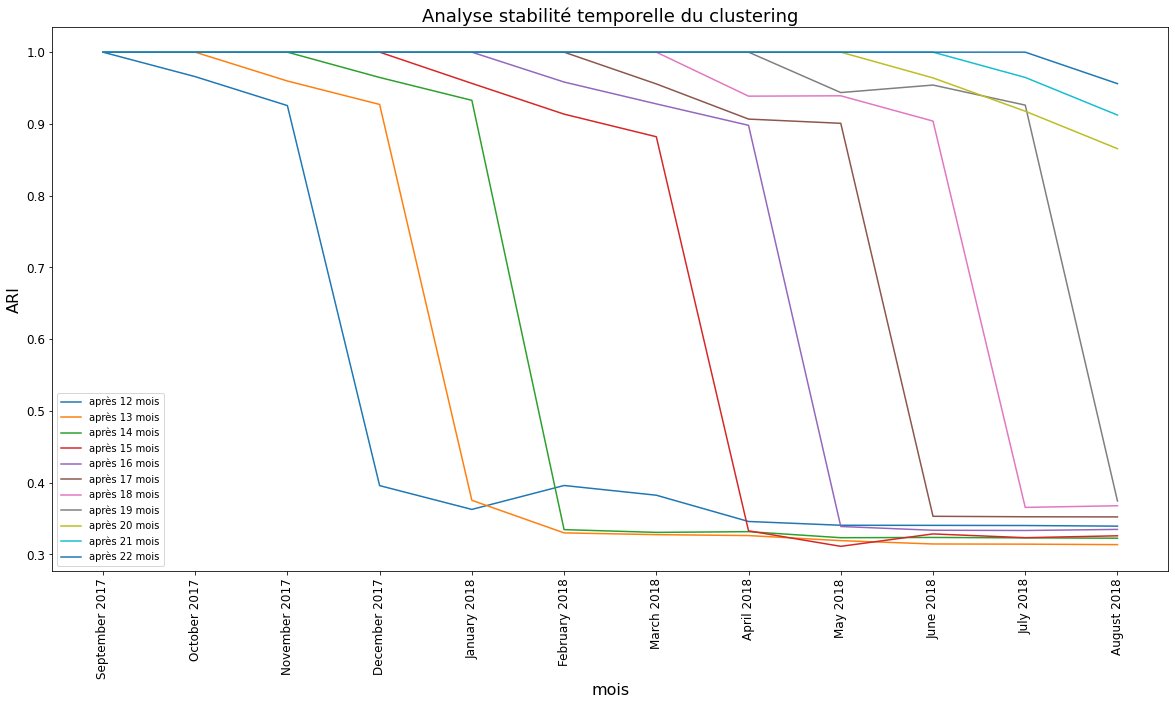

In [11]:
date = []
start_time = pd.to_datetime(
    order_data['order_purchase_timestamp'].min()) + relativedelta(months=12)
for i in range(0, ari_scores.shape[0]+1):
    date.append((start_time + relativedelta(months=i)).strftime('%B %Y'))

fig = plt.figure(figsize=[20, 10])
arr = np.linspace(0, 1, 11)
lbl = np.empty((arr.shape), dtype=object)
for i in range(0, 11):
    ari_scores_1 = np.concatenate(
        ([1]*(i+1), ari_scores[i, :(ari_scores.shape[0]-i)]), axis=0)
    plt.plot(date, ari_scores_1)
    lbl[i] = 'après ' + ("% s" % (i+12)) + ' mois'
plt.title('Analyse stabilité temporelle du clustering', fontsize=18)
plt.xlabel('mois', fontsize=16)
plt.ylabel('ARI', fontsize=16)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.legend(lbl)

Text(0, 0.5, 'count')

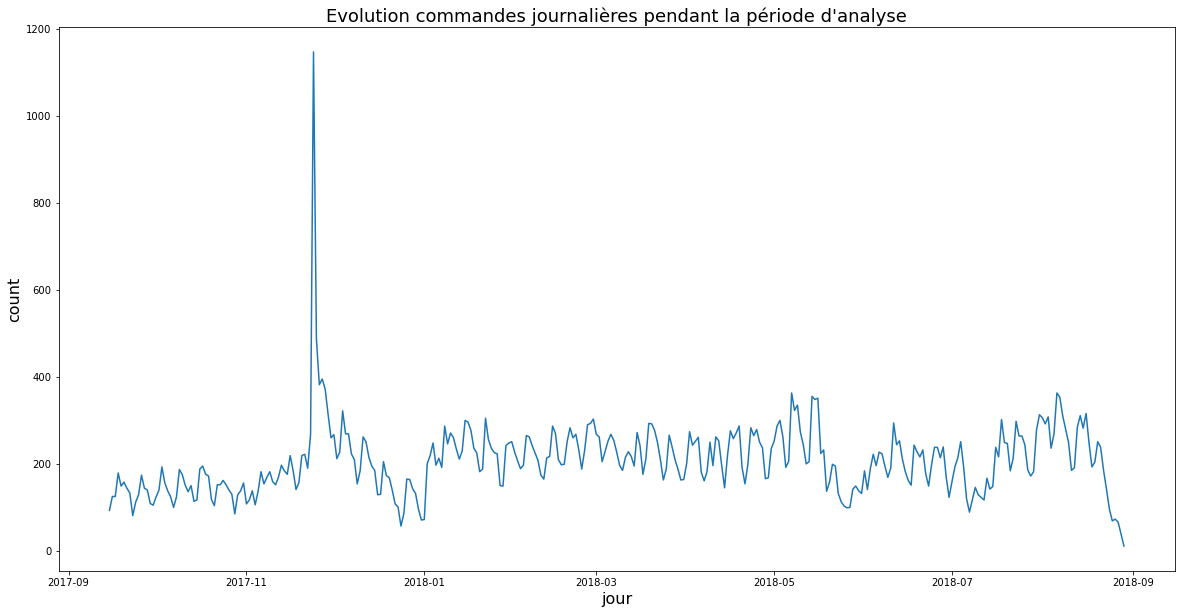

In [12]:
order_data.shape
order_data.head()
orders_per_days=order_data[pd.to_datetime(order_data['order_purchase_timestamp'])>start_time]
orders_per_days.shape
orders_per_days.min()
orders_per_days = orders_per_days.groupby(orders_per_days["order_purchase_timestamp"]\
                                      .astype('datetime64[ns]').dt.date)\
                                    .count()["order_id"]

fig = plt.figure(figsize=[20, 10])
plt.plot(orders_per_days)
plt.title("Evolution commandes journalières pendant la période d'analyse", fontsize=18)
plt.xlabel('jour', fontsize=16)
plt.ylabel('count', fontsize=16)